# Import and prep NY Times time series data for US states and counties

We use the NY Times data from https://github.com/nytimes/covid-19-data.

This notebook does the following:

* downloads lates time series data from https://github.com/nytimes/covid-19-data.
* adds an integer day column 
* all dataframes are created both in wide and long forms. 
* csvs explorted to path of your choosing
* line plots (faceted) by county (for MI) and by state


In [1]:
# Set your data export path to location where exported csvs will go.
use_local = True
if use_local:
    data_export_path = './myc19data/'
else:
    data_export_path = None

In [2]:
x_end_day = 700

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [4]:
import us # US states and metadata

In [5]:
%matplotlib inline

## Import raw data
The read csv statements below directly access the raw data residing on Github. I've also cloned the repo and can do a `git pull` to update my local copy of the entire repo. However, that is **NOT** necessary to use this notebook.

## Data from NY Times
Here's the URL to the raw data as stored at GitHub:

https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

You can get data directly from here but I'm also including code to grab it from a local repo of the NY Times site. This avoids repeated downloads if you are working on a notebook and keep rerunning all the cells.

In [6]:
# Get data directly from NYTimes and US census
if not use_local:
    NYT_counties_path = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
    NYT_states_path = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
    pop_path = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
else:
# Using local data that's already been downloaded or git pulled.
    local_data_path = os.environ['C19_HOME']
    NYT_counties_path = '{}/community/covid-19-data/us-counties.csv'.format(local_data_path)
    NYT_states_path = '{}/community/covid-19-data/us-states.csv'.format(local_data_path)
    pop_path = '{}/myc19data/co-est2019-alldata.csv'.format(local_data_path)

NYT_counties_df = pd.read_csv(NYT_counties_path, parse_dates=['date'])
NYT_states_df = pd.read_csv(NYT_states_path, parse_dates=['date'])
pop_df = pd.read_csv(pop_path, encoding = "utf-8")

In [7]:
pop_df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [8]:
pop_df['COUNTY'].dtype

dtype('int64')

In [9]:
pop_county_2019_df = pop_df.loc[pop_df['COUNTY'] > 0,['STATE', 'COUNTY', 'POPESTIMATE2019']]
pop_state_2019_df = pop_df.loc[pop_df['COUNTY'] == 0,['STATE', 'COUNTY', 'POPESTIMATE2019']]

In [10]:
pop_county_2019_df['fips'] = pop_county_2019_df['STATE'] * 1000 + pop_county_2019_df['COUNTY']
pop_county_2019_df

,STATE,COUNTY,POPESTIMATE2019,fips
1,1,1,55869,1001
2,1,3,223234,1003
3,1,5,24686,1005
4,1,7,22394,1007
5,1,9,57826,1009
...,...,...,...,...
3188,56,37,42343,56037
3189,56,39,23464,56039
3190,56,41,20226,56041
3191,56,43,7805,56043


In [11]:
pop_state_2019_df

,STATE,COUNTY,POPESTIMATE2019
0,1,0,4903185
68,2,0,731545
98,4,0,7278717
114,5,0,3017804
190,6,0,39512223
249,8,0,5758736
314,9,0,3565287
323,10,0,973764
327,11,0,705749
329,12,0,21477737


In [12]:
NYT_counties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702904 entries, 0 to 1702903
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   county  object        
 2   state   object        
 3   fips    float64       
 4   cases   int64         
 5   deaths  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 78.0+ MB


In [13]:
NYT_counties_df = NYT_counties_df.dropna()

In [14]:
NYT_counties_df = NYT_counties_df.astype({"fips": int})
NYT_states_df = NYT_states_df.astype({"fips": int})

In [15]:
NYT_counties_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648990 entries, 0 to 1702903
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   date    1648990 non-null  datetime64[ns]
 1   county  1648990 non-null  object        
 2   state   1648990 non-null  object        
 3   fips    1648990 non-null  int64         
 4   cases   1648990 non-null  int64         
 5   deaths  1648990 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 88.1+ MB


In [16]:
NYT_states_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [17]:
NYT_counties_df = NYT_counties_df.merge(pop_county_2019_df, how='left', left_on='fips', right_on='fips')
NYT_states_df = NYT_states_df.merge(pop_state_2019_df, how='left', left_on='fips', right_on='STATE')

In [18]:
NYT_counties_df

,date,county,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019
0,2020-01-21,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
3,2020-01-24,Cook,Illinois,17031,1,0.0,17.0,31.0,5150233.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
...,...,...,...,...,...,...,...,...,...
1648985,2021-09-09,Sweetwater,Wyoming,56037,6034,51.0,56.0,37.0,42343.0
1648986,2021-09-09,Teton,Wyoming,56039,4587,11.0,56.0,39.0,23464.0
1648987,2021-09-09,Uinta,Wyoming,56041,3168,16.0,56.0,41.0,20226.0
1648988,2021-09-09,Washakie,Wyoming,56043,1110,27.0,56.0,43.0,7805.0


In [19]:
NYT_states_df

,date,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019
0,2020-01-21,Washington,53,1,0,53.0,0.0,7614893.0
1,2020-01-22,Washington,53,1,0,53.0,0.0,7614893.0
2,2020-01-23,Washington,53,1,0,53.0,0.0,7614893.0
3,2020-01-24,Illinois,17,1,0,17.0,0.0,12671821.0
4,2020-01-24,Washington,53,1,0,53.0,0.0,7614893.0
...,...,...,...,...,...,...,...,...
30589,2021-09-09,Virginia,51,797348,12010,51.0,0.0,8535519.0
30590,2021-09-09,Washington,53,596505,6920,53.0,0.0,7614893.0
30591,2021-09-09,West Virginia,54,203404,3189,54.0,0.0,1792147.0
30592,2021-09-09,Wisconsin,55,751407,8589,55.0,0.0,5822434.0


### Check dates

In [20]:
num_dates = NYT_states_df['date'].describe()['unique']
print('{} unique dates'.format(num_dates))
date_stats = NYT_states_df['date'].describe()
print(date_stats)

598 unique dates
count                   30594
unique                    598
top       2021-04-09 00:00:00
freq                       55
first     2020-01-21 00:00:00
last      2021-09-09 00:00:00
Name: date, dtype: object


<ipython-input-20-0a7c8b33c870>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  num_dates = NYT_states_df['date'].describe()['unique']
<ipython-input-20-0a7c8b33c870>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  date_stats = NYT_states_df['date'].describe()


In [21]:
# Add integer day column for simple x-axis 
d0 = date_stats['first']
dn = date_stats['last']
NYT_counties_df['day'] = NYT_counties_df.loc[:, 'date'].map(lambda x: (x - d0).days)
NYT_states_df['day'] = NYT_states_df.loc[:, 'date'].map(lambda x: (x - d0).days)

## Add state abbreviations
We'll create a mapping dictionary from the `us` package.

In [22]:
us_state_abbrev = us.states.mapping('name', 'abbr')
#us_state_abbrev

In [23]:
NYT_counties_df.loc[:, 'st'] = NYT_counties_df.loc[:, 'state'].map(lambda x: us_state_abbrev[x])
NYT_states_df.loc[:, 'st'] = NYT_states_df.loc[:, 'state'].map(lambda x: us_state_abbrev[x])

In [24]:
NYT_counties_df.head()

,date,county,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,st
0,2020-01-21,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,0,WA
1,2020-01-22,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,1,WA
2,2020-01-23,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,2,WA
3,2020-01-24,Cook,Illinois,17031,1,0.0,17.0,31.0,5150233.0,3,IL
4,2020-01-24,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,3,WA


In [25]:
NYT_states_df.loc[NYT_states_df['state'] == 'Virginia'].tail()

,date,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,st
30369,2021-09-05,Virginia,51,778167,11899,51.0,0.0,8535519.0,593,VA
30424,2021-09-06,Virginia,51,786910,11929,51.0,0.0,8535519.0,594,VA
30479,2021-09-07,Virginia,51,788917,11947,51.0,0.0,8535519.0,595,VA
30534,2021-09-08,Virginia,51,793396,11977,51.0,0.0,8535519.0,596,VA
30589,2021-09-09,Virginia,51,797348,12010,51.0,0.0,8535519.0,597,VA


## Compute some first diffs
Be nice to have first diffs of the cumulative counts and some 1-week moving averages. Have to be careful because dataframes are ordered by date by location and direct diffs make no sense. There's also some pandas trickiness with these, especially the rolling means within groups.

In [26]:
NYT_states_df = NYT_states_df.sort_values(by=['state', 'date'])
NYT_states_df['cases_diff'] = NYT_states_df.groupby(['state'])['cases'].diff().fillna(0)
NYT_states_df['cases_ma7'] = NYT_states_df.groupby('state')['cases_diff'].transform(lambda x: x.rolling(7, 1).mean())
NYT_states_df['cases_ma14'] = NYT_states_df.groupby('state')['cases_diff'].transform(lambda x: x.rolling(14, 1).mean())
NYT_states_df['deaths_diff'] = NYT_states_df.groupby(['state'])['deaths'].diff().fillna(0)
NYT_states_df['deaths_ma7'] = NYT_states_df.groupby('state')['deaths_diff'].transform(lambda x: x.rolling(7, 1).mean())
NYT_states_df['deaths_ma14'] = NYT_states_df.groupby('state')['deaths_diff'].transform(lambda x: x.rolling(14, 1).mean())

NYT_counties_df = NYT_counties_df.sort_values(by=['state', 'county', 'fips', 'date'])
# NYT_counties_df.info() - there all nulls for some counties due to unknown fips
NYT_counties_df.dropna(inplace=True)

NYT_counties_df['cases_diff'] = NYT_counties_df.groupby(['fips'])['cases'].diff().fillna(0)
NYT_counties_df['cases_ma7'] = \
    NYT_counties_df.groupby('fips')['cases_diff'].transform(lambda x: x.rolling(7, 1).mean())
NYT_counties_df['deaths_diff'] = NYT_counties_df.groupby(['fips'])['deaths'].diff().fillna(0)
NYT_counties_df['deaths_ma7'] = \
    NYT_counties_df.groupby('fips')['deaths_diff'].transform(lambda x: x.rolling(7, 1).mean())

In [27]:
NYT_states_df.head()

,date,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,st,cases_diff,cases_ma7,cases_ma14,deaths_diff,deaths_ma7,deaths_ma14
586,2020-03-13,Alabama,1,6,0,1.0,0.0,4903185.0,52,AL,0.0,0.000000,0.000000,0.0,0.0,0.0
637,2020-03-14,Alabama,1,12,0,1.0,0.0,4903185.0,53,AL,6.0,3.000000,3.000000,0.0,0.0,0.0
689,2020-03-15,Alabama,1,23,0,1.0,0.0,4903185.0,54,AL,11.0,5.666667,5.666667,0.0,0.0,0.0
742,2020-03-16,Alabama,1,29,0,1.0,0.0,4903185.0,55,AL,6.0,5.750000,5.750000,0.0,0.0,0.0
795,2020-03-17,Alabama,1,39,0,1.0,0.0,4903185.0,56,AL,10.0,6.600000,6.600000,0.0,0.0,0.0


In [28]:
NYT_counties_df.head()

,date,county,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,st,cases_diff,cases_ma7,deaths_diff,deaths_ma7
9327,2020-03-24,Autauga,Alabama,1001,1,0.0,1.0,1.0,55869.0,63,AL,0.0,0.000000,0.0,0.0
10656,2020-03-25,Autauga,Alabama,1001,4,0.0,1.0,1.0,55869.0,64,AL,3.0,1.500000,0.0,0.0
12162,2020-03-26,Autauga,Alabama,1001,6,0.0,1.0,1.0,55869.0,65,AL,2.0,1.666667,0.0,0.0
13795,2020-03-27,Autauga,Alabama,1001,6,0.0,1.0,1.0,55869.0,66,AL,0.0,1.250000,0.0,0.0
15548,2020-03-28,Autauga,Alabama,1001,6,0.0,1.0,1.0,55869.0,67,AL,0.0,1.000000,0.0,0.0


## Rename columns
Sinces cases is actually cumulative cases...

In [29]:
NYT_states_df.rename(columns={'cases': 'cases_cum',
                             'cases_diff': 'cases',
                             'deaths': 'deaths_cum',
                             'deaths_diff': 'deaths',}, inplace=True)

NYT_counties_df.rename(columns={'cases': 'cases_cum',
                             'cases_diff': 'cases',
                             'deaths': 'deaths_cum',
                             'deaths_diff': 'deaths',}, inplace=True)

NYT_states_df.head()

,date,state,fips,cases_cum,deaths_cum,STATE,COUNTY,POPESTIMATE2019,day,st,cases,cases_ma7,cases_ma14,deaths,deaths_ma7,deaths_ma14
586,2020-03-13,Alabama,1,6,0,1.0,0.0,4903185.0,52,AL,0.0,0.000000,0.000000,0.0,0.0,0.0
637,2020-03-14,Alabama,1,12,0,1.0,0.0,4903185.0,53,AL,6.0,3.000000,3.000000,0.0,0.0,0.0
689,2020-03-15,Alabama,1,23,0,1.0,0.0,4903185.0,54,AL,11.0,5.666667,5.666667,0.0,0.0,0.0
742,2020-03-16,Alabama,1,29,0,1.0,0.0,4903185.0,55,AL,6.0,5.750000,5.750000,0.0,0.0,0.0
795,2020-03-17,Alabama,1,39,0,1.0,0.0,4903185.0,56,AL,10.0,6.600000,6.600000,0.0,0.0,0.0


## Compute per capita cases (per 100000 pop)

In [30]:
NYT_states_df['cases_ma7_per100k'] = NYT_states_df['cases_ma7'] / (NYT_states_df['POPESTIMATE2019'] / 100000)
NYT_counties_df['cases_ma7_per100k'] = NYT_counties_df['cases_ma7'] / (NYT_counties_df['POPESTIMATE2019'] / 100000)

NYT_states_df['deaths_ma7_per100k'] = NYT_states_df['deaths_ma7'] / (NYT_states_df['POPESTIMATE2019'] / 100000)
NYT_counties_df['deaths_ma7_per100k'] = NYT_counties_df['deaths_ma7'] / (NYT_counties_df['POPESTIMATE2019'] / 100000)

NYT_states_df

,date,state,fips,cases_cum,deaths_cum,STATE,COUNTY,POPESTIMATE2019,day,st,cases,cases_ma7,cases_ma14,deaths,deaths_ma7,deaths_ma14,cases_ma7_per100k,deaths_ma7_per100k
586,2020-03-13,Alabama,1,6,0,1.0,0.0,4903185.0,52,AL,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
637,2020-03-14,Alabama,1,12,0,1.0,0.0,4903185.0,53,AL,6.0,3.000000,3.000000,0.0,0.000000,0.000000,0.061185,0.000000
689,2020-03-15,Alabama,1,23,0,1.0,0.0,4903185.0,54,AL,11.0,5.666667,5.666667,0.0,0.000000,0.000000,0.115571,0.000000
742,2020-03-16,Alabama,1,29,0,1.0,0.0,4903185.0,55,AL,6.0,5.750000,5.750000,0.0,0.000000,0.000000,0.117271,0.000000
795,2020-03-17,Alabama,1,39,0,1.0,0.0,4903185.0,56,AL,10.0,6.600000,6.600000,0.0,0.000000,0.000000,0.134606,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30373,2021-09-05,Wyoming,56,77206,858,56.0,0.0,578759.0,593,WY,0.0,534.142857,466.785714,0.0,3.285714,3.500000,92.291067,0.567717
30428,2021-09-06,Wyoming,56,77206,858,56.0,0.0,578759.0,594,WY,0.0,350.000000,403.142857,0.0,3.285714,3.500000,60.474222,0.567717
30483,2021-09-07,Wyoming,56,78495,879,56.0,0.0,578759.0,595,WY,1289.0,479.857143,459.000000,21.0,3.000000,3.142857,82.911392,0.518350
30538,2021-09-08,Wyoming,56,79297,879,56.0,0.0,578759.0,596,WY,802.0,470.000000,483.500000,0.0,3.000000,3.142857,81.208240,0.518350


## Wide to long format by melting the measures

In [31]:
NYT_states_long_df = pd.melt(NYT_states_df, 
  id_vars=['date', 'state', 'fips', 'day', 'st'],
                       value_vars=['cases', 'deaths', 'cases_cum', 'deaths_cum', 'cases_ma7', 'deaths_ma7', 'cases_ma7_per100k'],
                       var_name='measure', value_name='cases')

NYT_counties_long_df = pd.melt(NYT_counties_df, 
  id_vars=['date', 'county', 'state', 'fips', 'day', 'st'],
                       value_vars=['cases', 'deaths', 'cases_cum', 'deaths_cum', 'cases_ma7', 'deaths_ma7', 'cases_ma7_per100k'],
                       var_name='measure', value_name='cases')

/home/mark/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Export results

In [32]:
if data_export_path:
    NYT_counties_df.to_csv("{}NYT_counties.csv".format(data_export_path), index=False)
    NYT_states_df.to_csv("{}NYT_states.csv".format(data_export_path), index=False)

    NYT_counties_long_df.to_csv("{}NYT_counties_long.csv".format(data_export_path), index=False)
    NYT_states_long_df.to_csv("{}NYT_states_long.csv".format(data_export_path), index=False)

## Sample plots

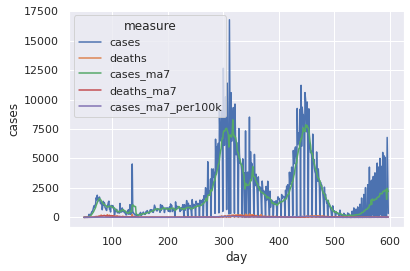

In [33]:
sns.lineplot(x='day', y='cases', hue='measure', 
             data=NYT_states_long_df.loc[(NYT_states_long_df['st'] == 'MI') & 
                                         (NYT_states_long_df['measure'] != 'cases_cum') &
                                         (NYT_states_long_df['measure'] != 'deaths_cum')]);

<AxesSubplot:xlabel='day', ylabel='cases'>

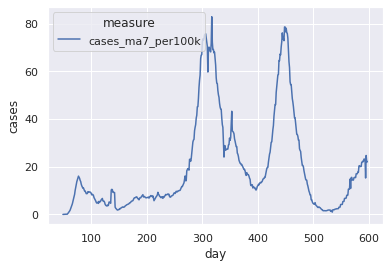

In [34]:
sns.lineplot(x='day', y='cases', hue='measure', 
             data=NYT_states_long_df.loc[(NYT_states_long_df['st'] == 'MI') & 
                                         (NYT_states_long_df['measure'] == 'cases_ma7_per100k')])

In [35]:
mich_df = NYT_counties_df.loc[NYT_counties_df['st'].isin(['MI'])]
mich_df.to_csv('mich_df.csv', index=None)
mich_df

,date,county,state,fips,cases_cum,deaths_cum,STATE,COUNTY,POPESTIMATE2019,day,st,cases,cases_ma7,deaths,deaths_ma7,cases_ma7_per100k,deaths_ma7_per100k
59461,2020-04-15,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,85,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
62154,2020-04-16,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,86,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
64863,2020-04-17,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,87,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
67581,2020-04-18,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,88,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
70315,2020-04-19,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,89,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634601,2021-09-05,Wexford,Michigan,26165,3005,49.0,26.0,165.0,33631.0,593,MI,0.0,3.857143,0.0,0.142857,11.469010,0.424778
1637741,2021-09-06,Wexford,Michigan,26165,3005,49.0,26.0,165.0,33631.0,594,MI,0.0,2.285714,0.0,0.142857,6.796451,0.424778
1640881,2021-09-07,Wexford,Michigan,26165,3013,50.0,26.0,165.0,33631.0,595,MI,8.0,3.428571,1.0,0.285714,10.194676,0.849556
1644021,2021-09-08,Wexford,Michigan,26165,3014,50.0,26.0,165.0,33631.0,596,MI,1.0,2.428571,0.0,0.142857,7.221229,0.424778


In [36]:
semi_counties = ['Oakland', 'Macomb', 'Wayne', 'Washtenaw', 'St. Clair', 'Genesee', 'Monroe', 'Lapeer']
semich_df = NYT_counties_df.loc[NYT_counties_df['county'].isin(semi_counties) & NYT_counties_df['st'].isin(['MI'])]
semich_df.to_csv('semich_df.csv', index=None)
semich_df

,date,county,state,fips,cases_cum,deaths_cum,STATE,COUNTY,POPESTIMATE2019,day,st,cases,cases_ma7,deaths,deaths_ma7,cases_ma7_per100k,deaths_ma7_per100k
4675,2020-03-19,Genesee,Michigan,26049,1,0.0,26.0,49.0,405813.0,58,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
5480,2020-03-20,Genesee,Michigan,26049,1,0.0,26.0,49.0,405813.0,59,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
6429,2020-03-21,Genesee,Michigan,26049,7,0.0,26.0,49.0,405813.0,60,MI,6.0,2.000000,0.0,0.000000,0.492838,0.000000
7487,2020-03-22,Genesee,Michigan,26049,14,0.0,26.0,49.0,405813.0,61,MI,7.0,3.250000,0.0,0.000000,0.800861,0.000000
8638,2020-03-23,Genesee,Michigan,26049,23,0.0,26.0,49.0,405813.0,62,MI,9.0,4.400000,0.0,0.000000,1.084243,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634600,2021-09-05,Wayne,Michigan,26163,177167,5312.0,26.0,163.0,1749343.0,593,MI,0.0,298.428571,0.0,4.857143,17.059466,0.277655
1637740,2021-09-06,Wayne,Michigan,26163,177167,5312.0,26.0,163.0,1749343.0,594,MI,0.0,187.571429,0.0,4.000000,10.722393,0.228657
1640880,2021-09-07,Wayne,Michigan,26163,178053,5319.0,26.0,163.0,1749343.0,595,MI,886.0,314.142857,7.0,5.000000,17.957762,0.285822
1644020,2021-09-08,Wayne,Michigan,26163,178474,5333.0,26.0,163.0,1749343.0,596,MI,421.0,280.142857,14.0,4.142857,16.014175,0.236824


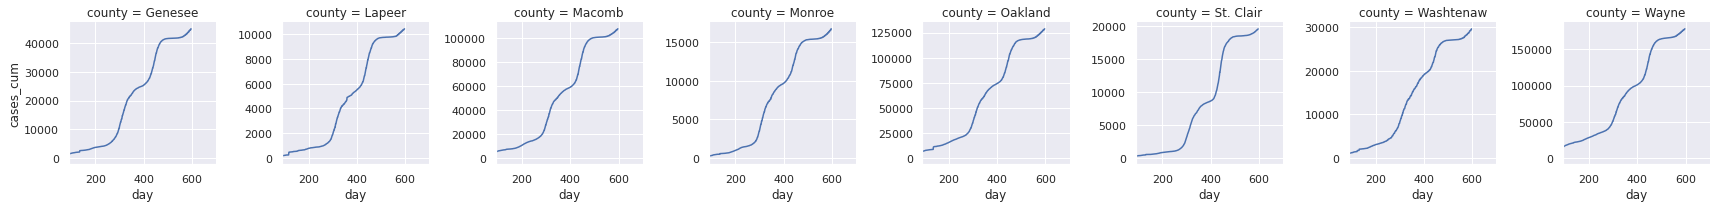

In [37]:
g = sns.FacetGrid(semich_df, col="county", sharey=False)
g = g.map(plt.plot, "day", "cases_cum")
g.set(xlim=(90,x_end_day))

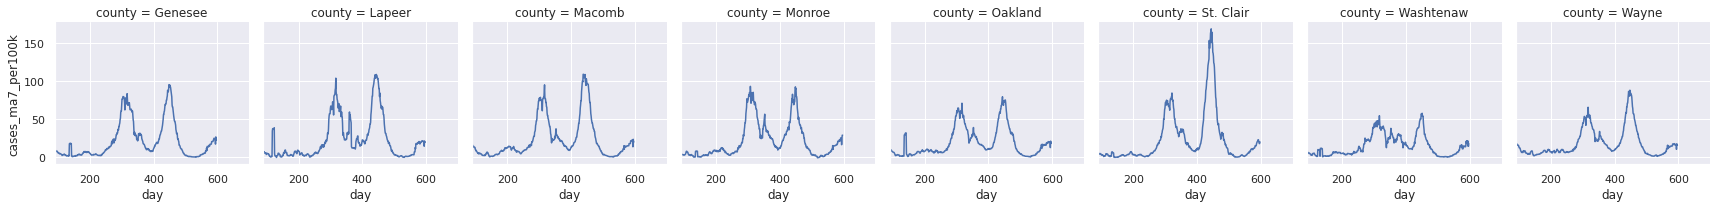

In [38]:
g = sns.FacetGrid(semich_df, col="county", sharey=True)
g = g.map(plt.plot, "day", "cases_ma7_per100k")
g.set(xlim=(90,x_end_day))
g.savefig('semich_7ma_cases_per100k.jpg')

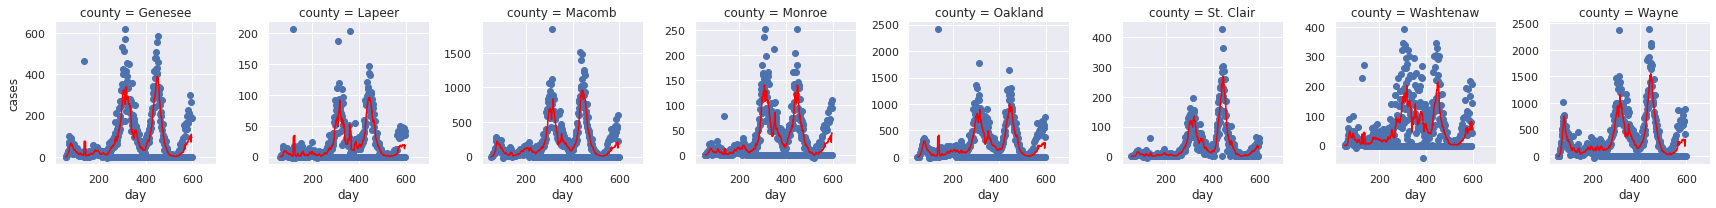

In [39]:
g = sns.FacetGrid(semich_df, col="county", sharey=False)
g = g.map(plt.plot, "day", "cases_ma7", color="red")
g = g.map(plt.scatter, "day", "cases")
g.set(xlim=(10,x_end_day))
g.savefig('semich_cases.jpg')

In [40]:
title = 'Daily cases through {}'.format(dn.strftime('%Y-%m-%d'))
title

'Daily cases through 2021-09-09'

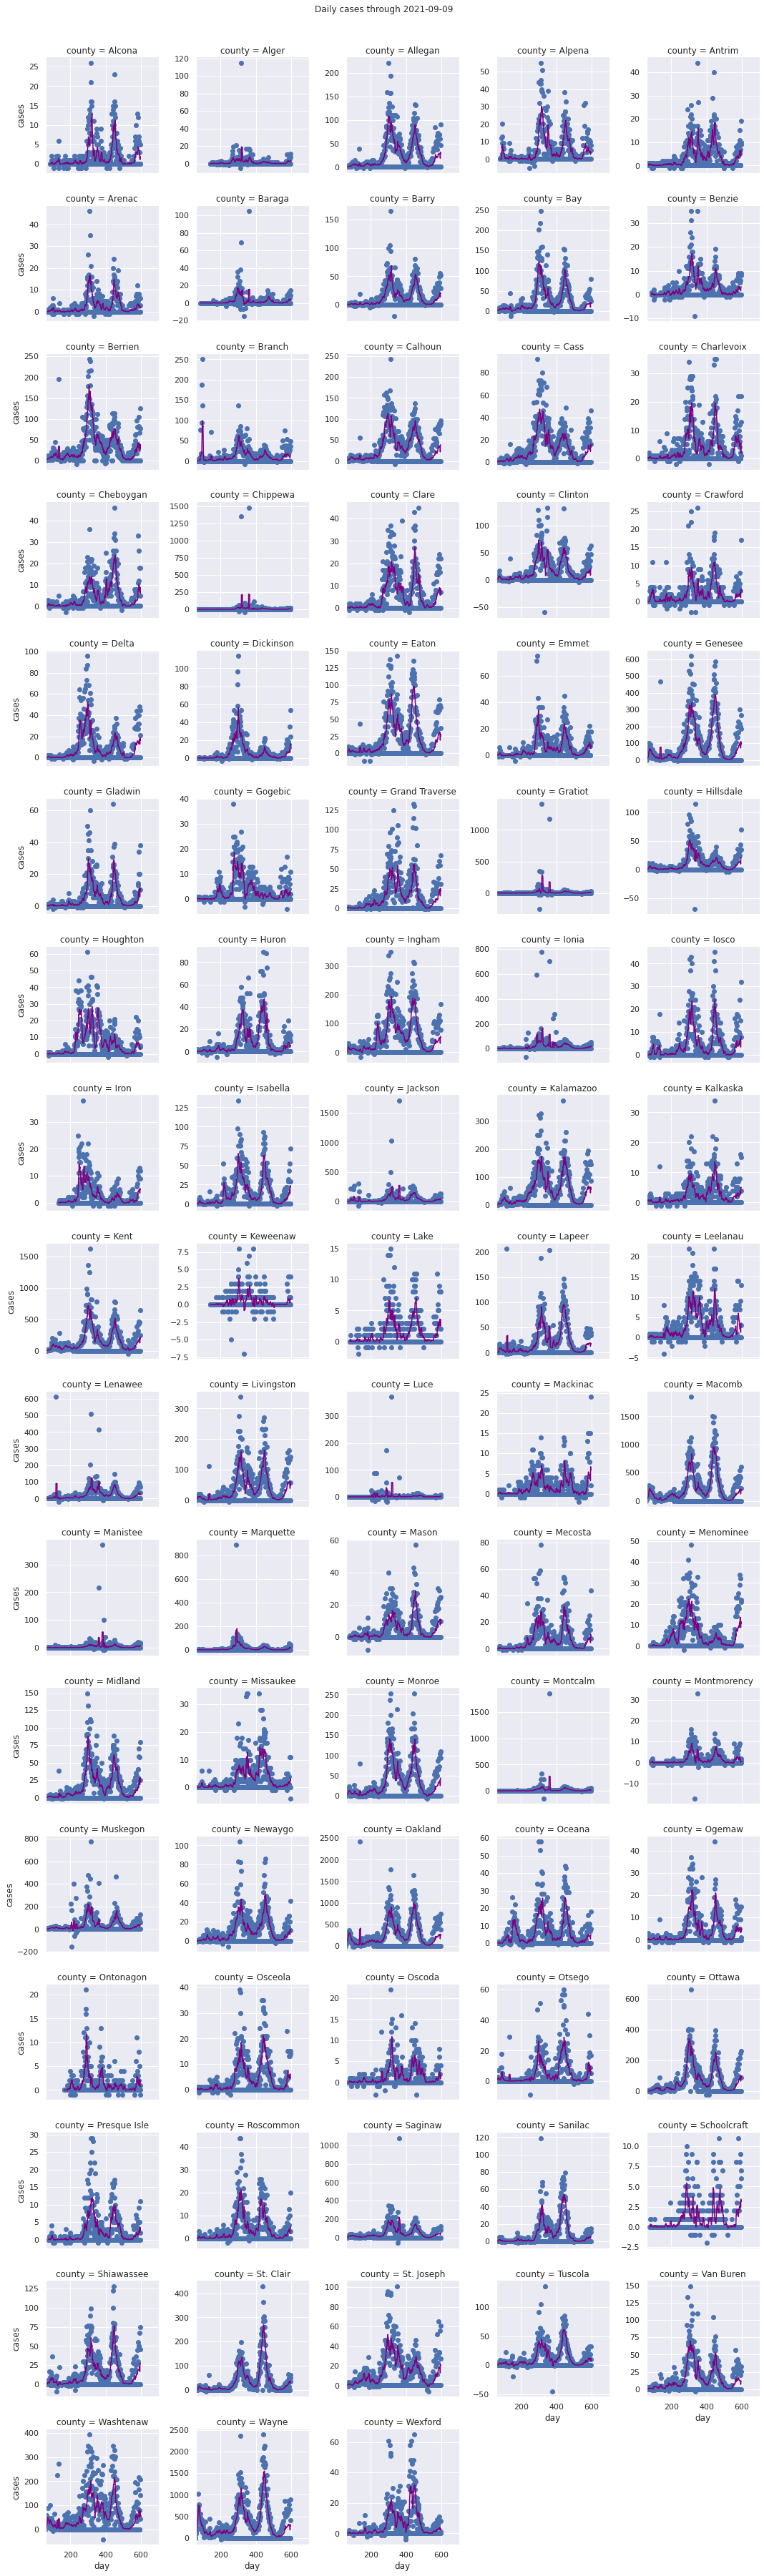

In [41]:
g_mich_cases = sns.FacetGrid(mich_df, col="county", sharey=False, 
                         col_wrap=5)
g_mich_cases = g_mich_cases.map(plt.plot, "day", "cases_ma7", color="purple")
g_mich_cases = g_mich_cases.map(plt.scatter, "day", "cases")

g_mich_cases.set(xlim=(60,x_end_day))

plt.subplots_adjust(top=0.96)
g_mich_cases.fig.suptitle(title) # can also get the figure from plt.gcf()

g_mich_cases.savefig("mich_cases.jpg")

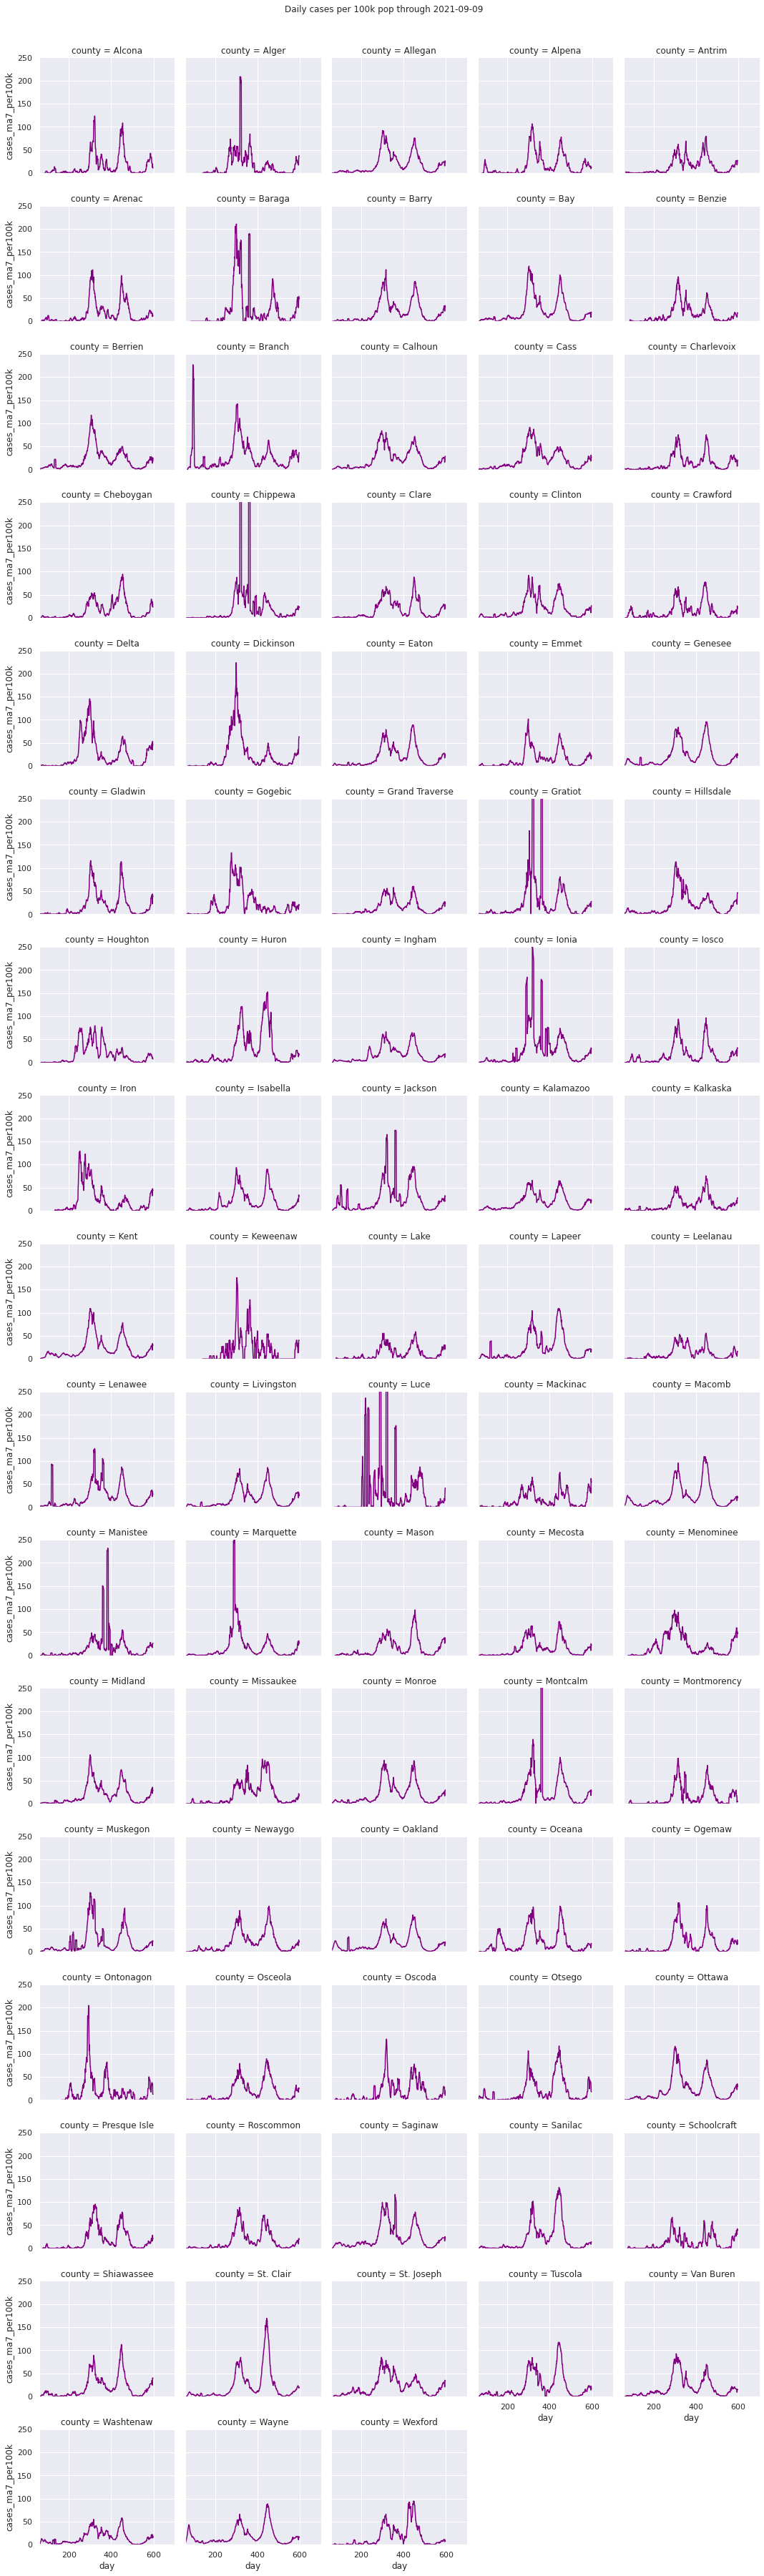

In [42]:
title = 'Daily cases per 100k pop through {}'.format(dn.strftime('%Y-%m-%d'))
g_mich_cases = sns.FacetGrid(mich_df, col="county", sharey=True, 
                         col_wrap=5)
g_mich_cases = g_mich_cases.map(plt.plot, "day", "cases_ma7_per100k", color="purple")

g_mich_cases.set(xlim=(60,x_end_day), ylim=(0,250))

plt.subplots_adjust(top=0.96)
g_mich_cases.fig.suptitle(title) # can also get the figure from plt.gcf()

g_mich_cases.savefig("mich_cases_per100k.png")

In [43]:
semich_cases_by_date = semich_df.groupby(['date'])[['cases', 'cases_cum']].sum()

In [44]:
semich_cases_by_date.to_csv('semich_cases_by_date.csv')

In [45]:
semich_cases_by_date

,cases,cases_cum
date,,
2020-03-10,0.0,2
2020-03-11,0.0,2
2020-03-12,2.0,7
2020-03-13,9.0,17
2020-03-14,7.0,25
...,...,...
2021-09-05,38.0,531715
2021-09-06,0.0,531715
2021-09-07,2882.0,534597


<AxesSubplot:xlabel='date'>

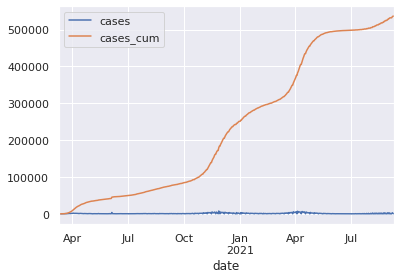

In [46]:
semich_cases_by_date.plot()

In [47]:
some_states = ['TX', 'NY', 'NC', 'FL', 'CA', 'CO', 'GA']
some_states_df = NYT_states_df.loc[NYT_states_df['st'].isin(some_states)]

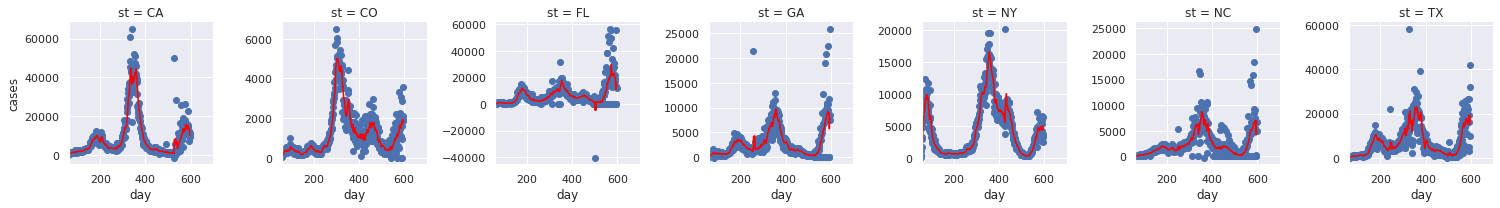

In [48]:
g = sns.FacetGrid(some_states_df, col="st", sharey=False)
g = g.map(plt.plot, "day", "cases_ma7", color="red")
g = g.map(plt.scatter, "day", "cases")
g.set(xlim=(60,x_end_day))

In [49]:
abbrevs = [state.abbr for state in us.states.STATES]

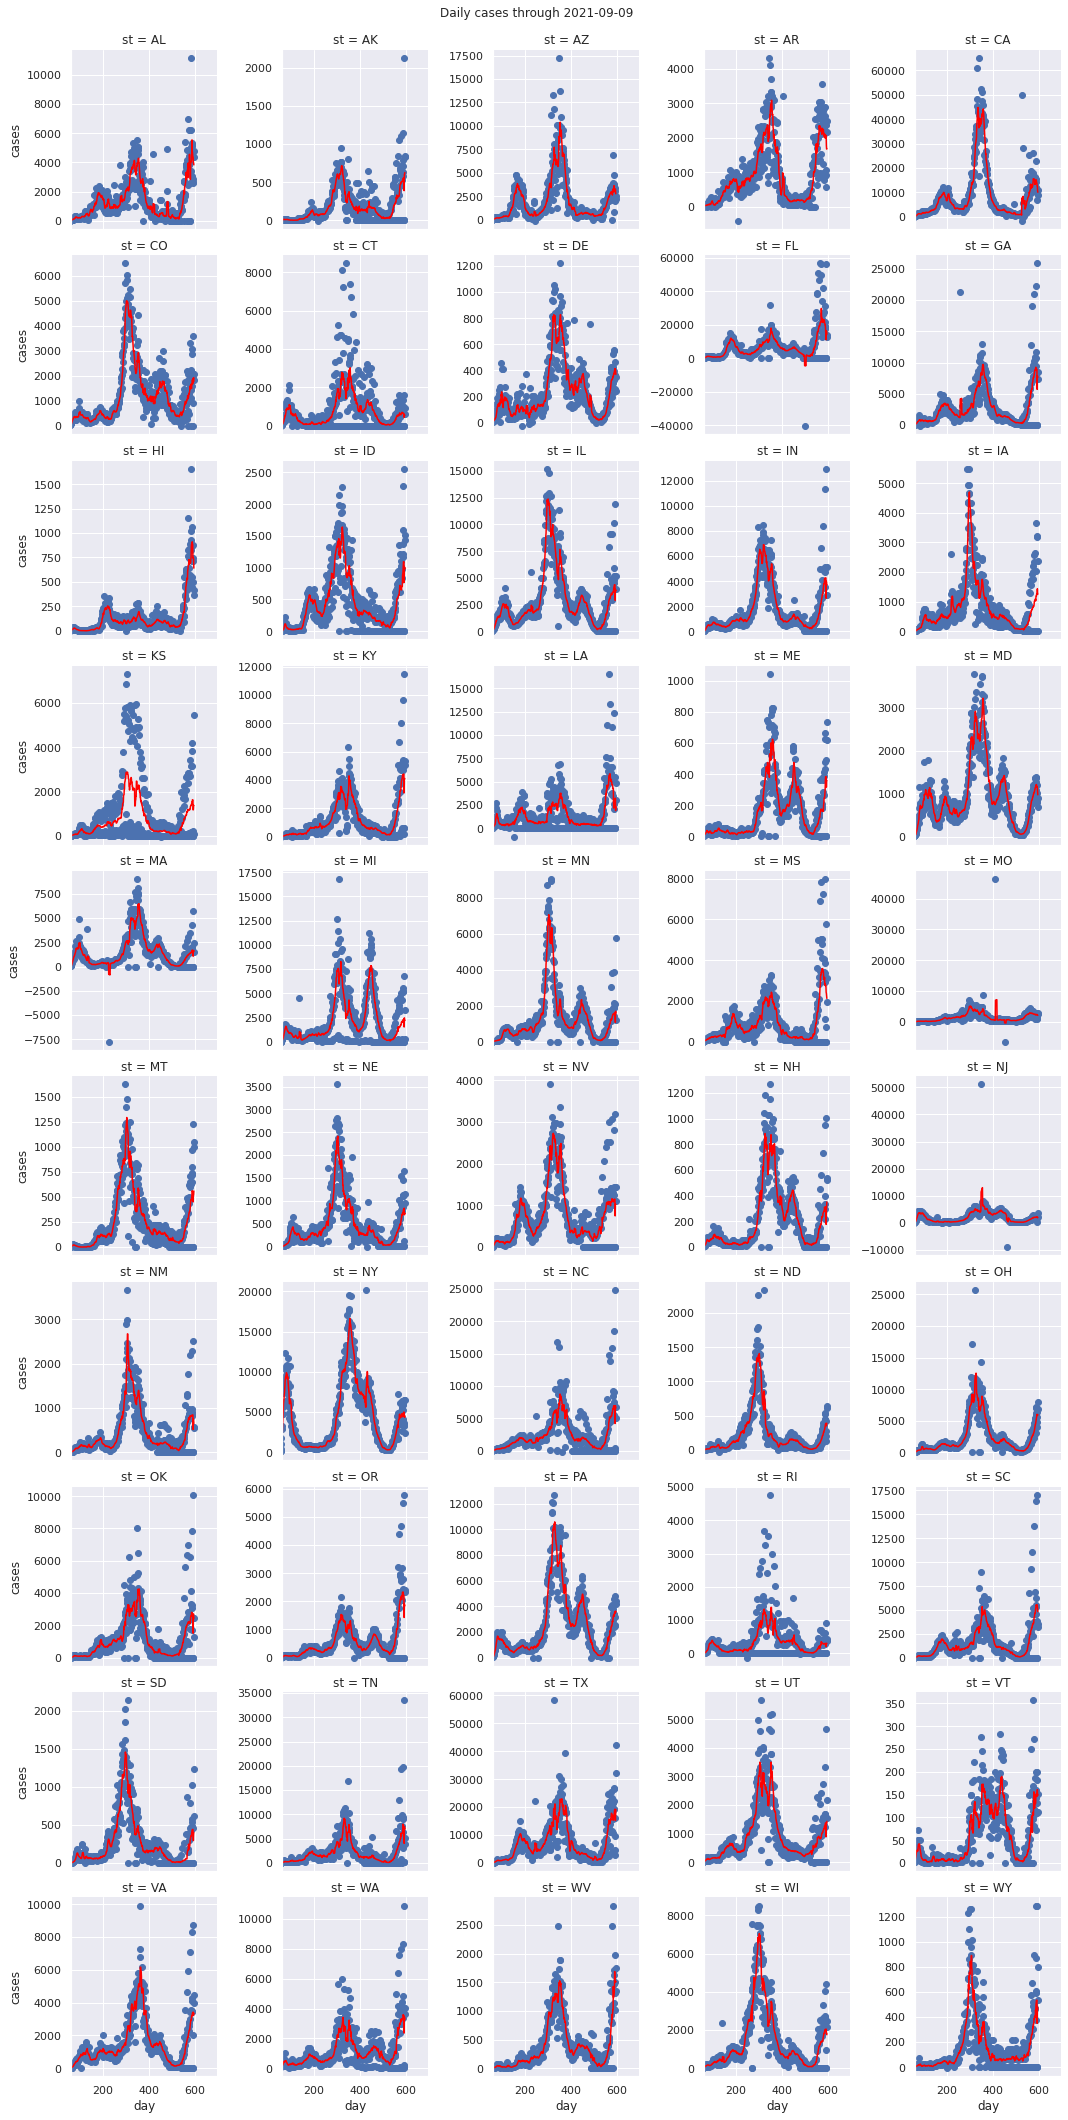

In [50]:
title = 'Daily cases through {}'.format(dn.strftime('%Y-%m-%d'))
g_states_cases = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states_cases = g_states_cases.map(plt.plot, "day", "cases_ma7", color="red")
g_states_cases = g_states_cases.map(plt.scatter, "day", "cases")
g_states_cases.set(xlim=(60,x_end_day))

plt.subplots_adjust(top=0.96)
g_states_cases.fig.suptitle(title) # can also get the figure from plt.gcf()

g_states_cases.savefig("us_cases.png")

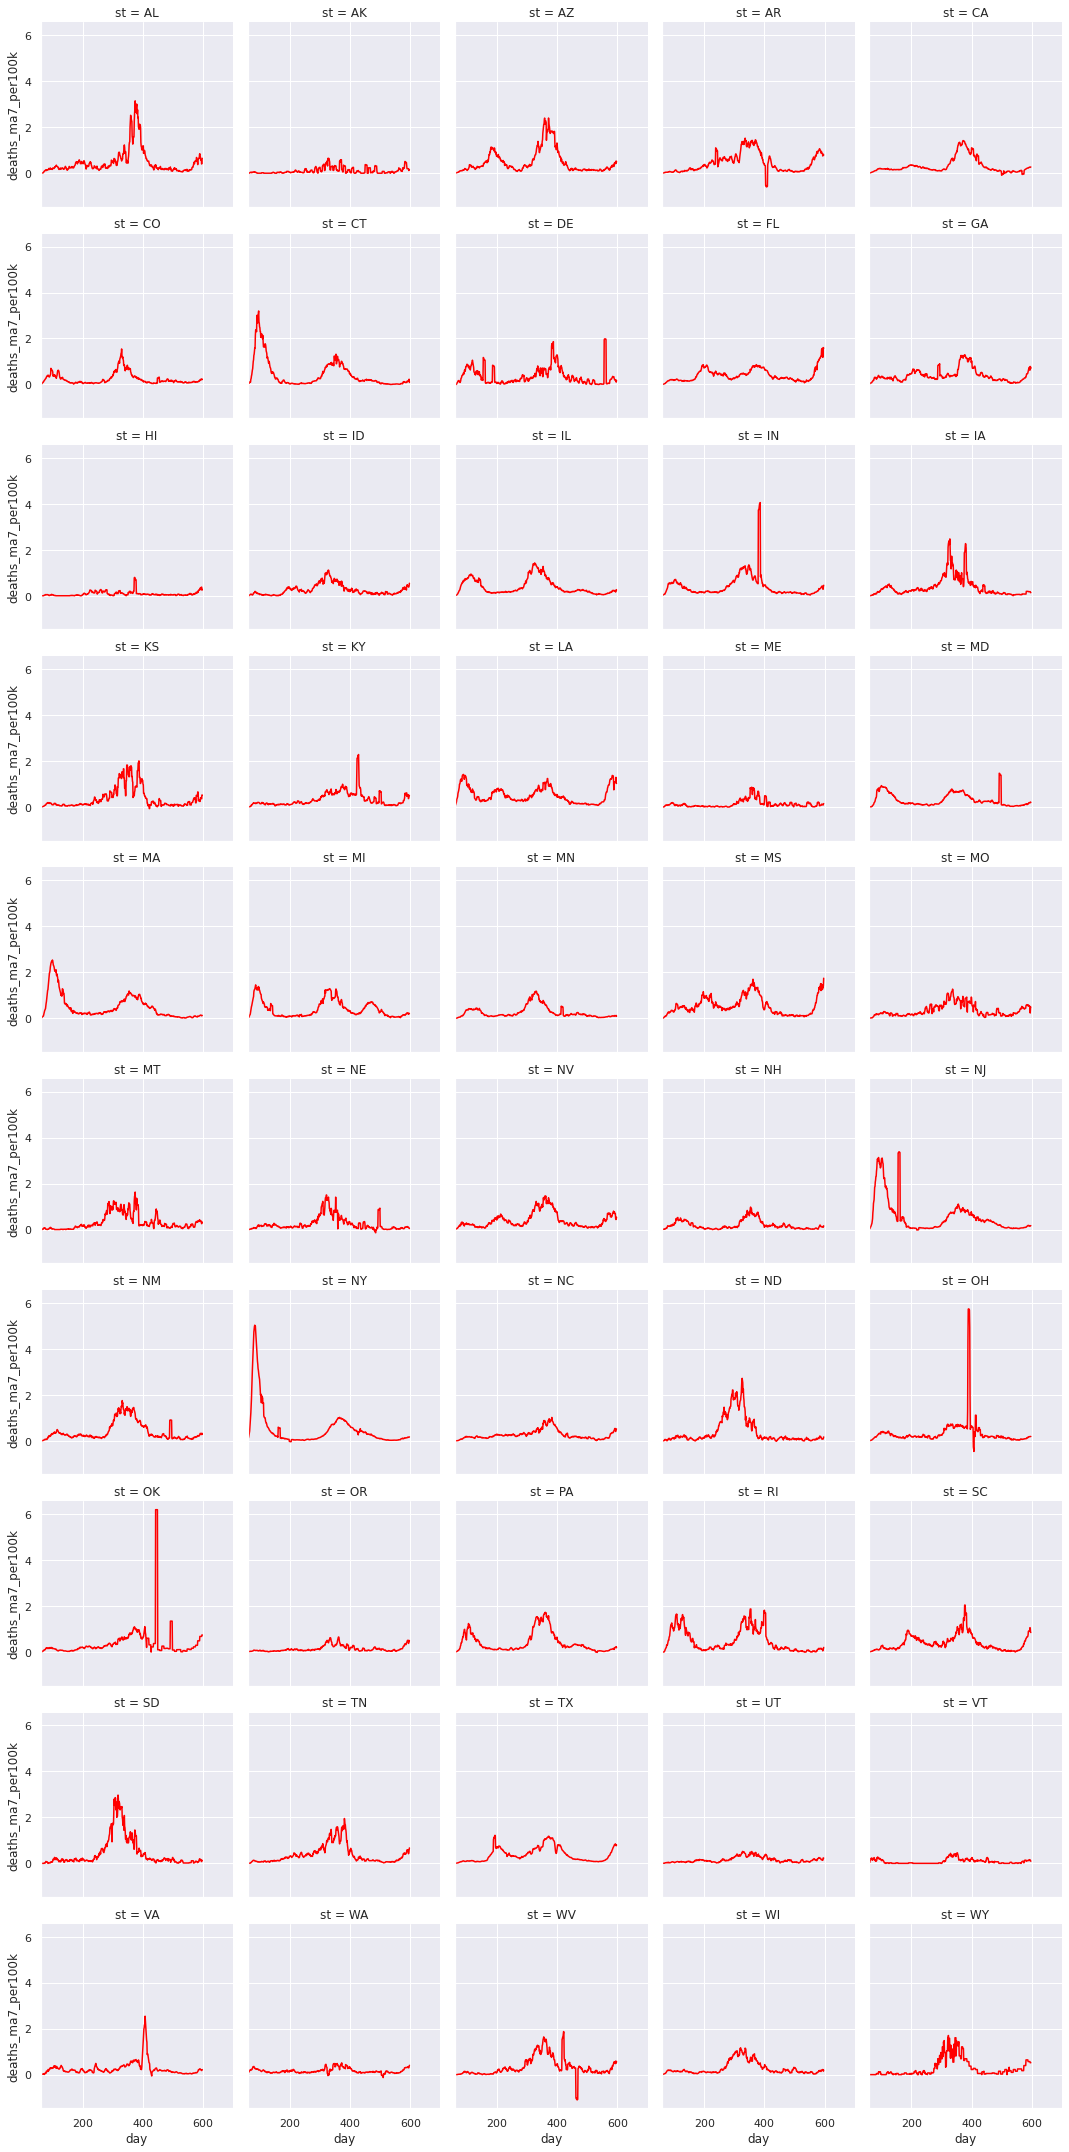

In [51]:
title = 'Daily deaths per 100k pop through {}'.format(dn.strftime('%Y-%m-%d'))
g_states_deaths = sns.FacetGrid(NYT_states_df, col="st", sharey=True, 
                         col_wrap=5, col_order=abbrevs)
g_states_deaths = g_states_deaths.map(plt.plot, "day", "deaths_ma7_per100k", color="red")
g_states_deaths.set(xlim=(60,x_end_day))

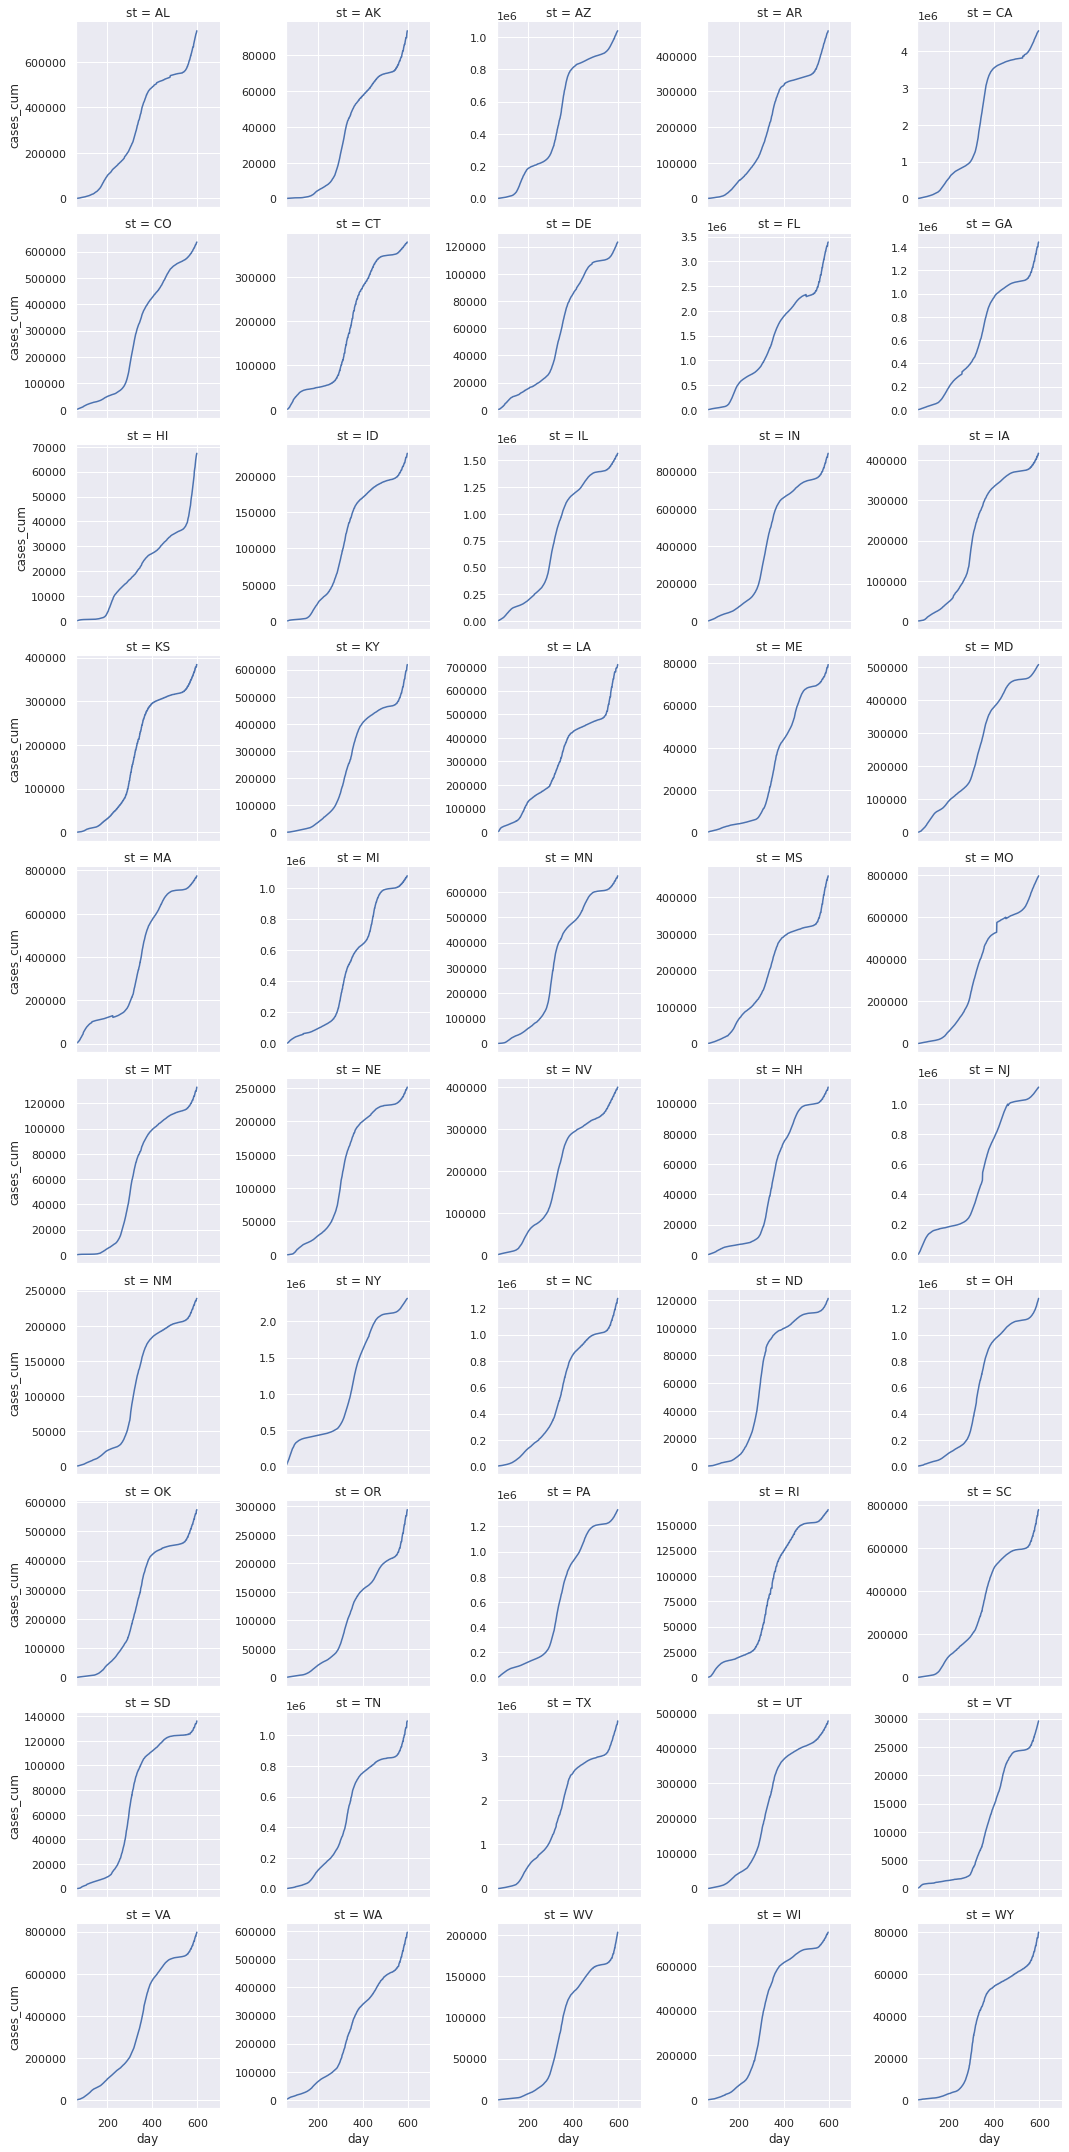

In [52]:
g_states_cases_cum = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states_cases_cum = g_states_cases_cum.map(plt.plot, "day", "cases_cum")
g_states_cases_cum.set(xlim=(60,x_end_day))

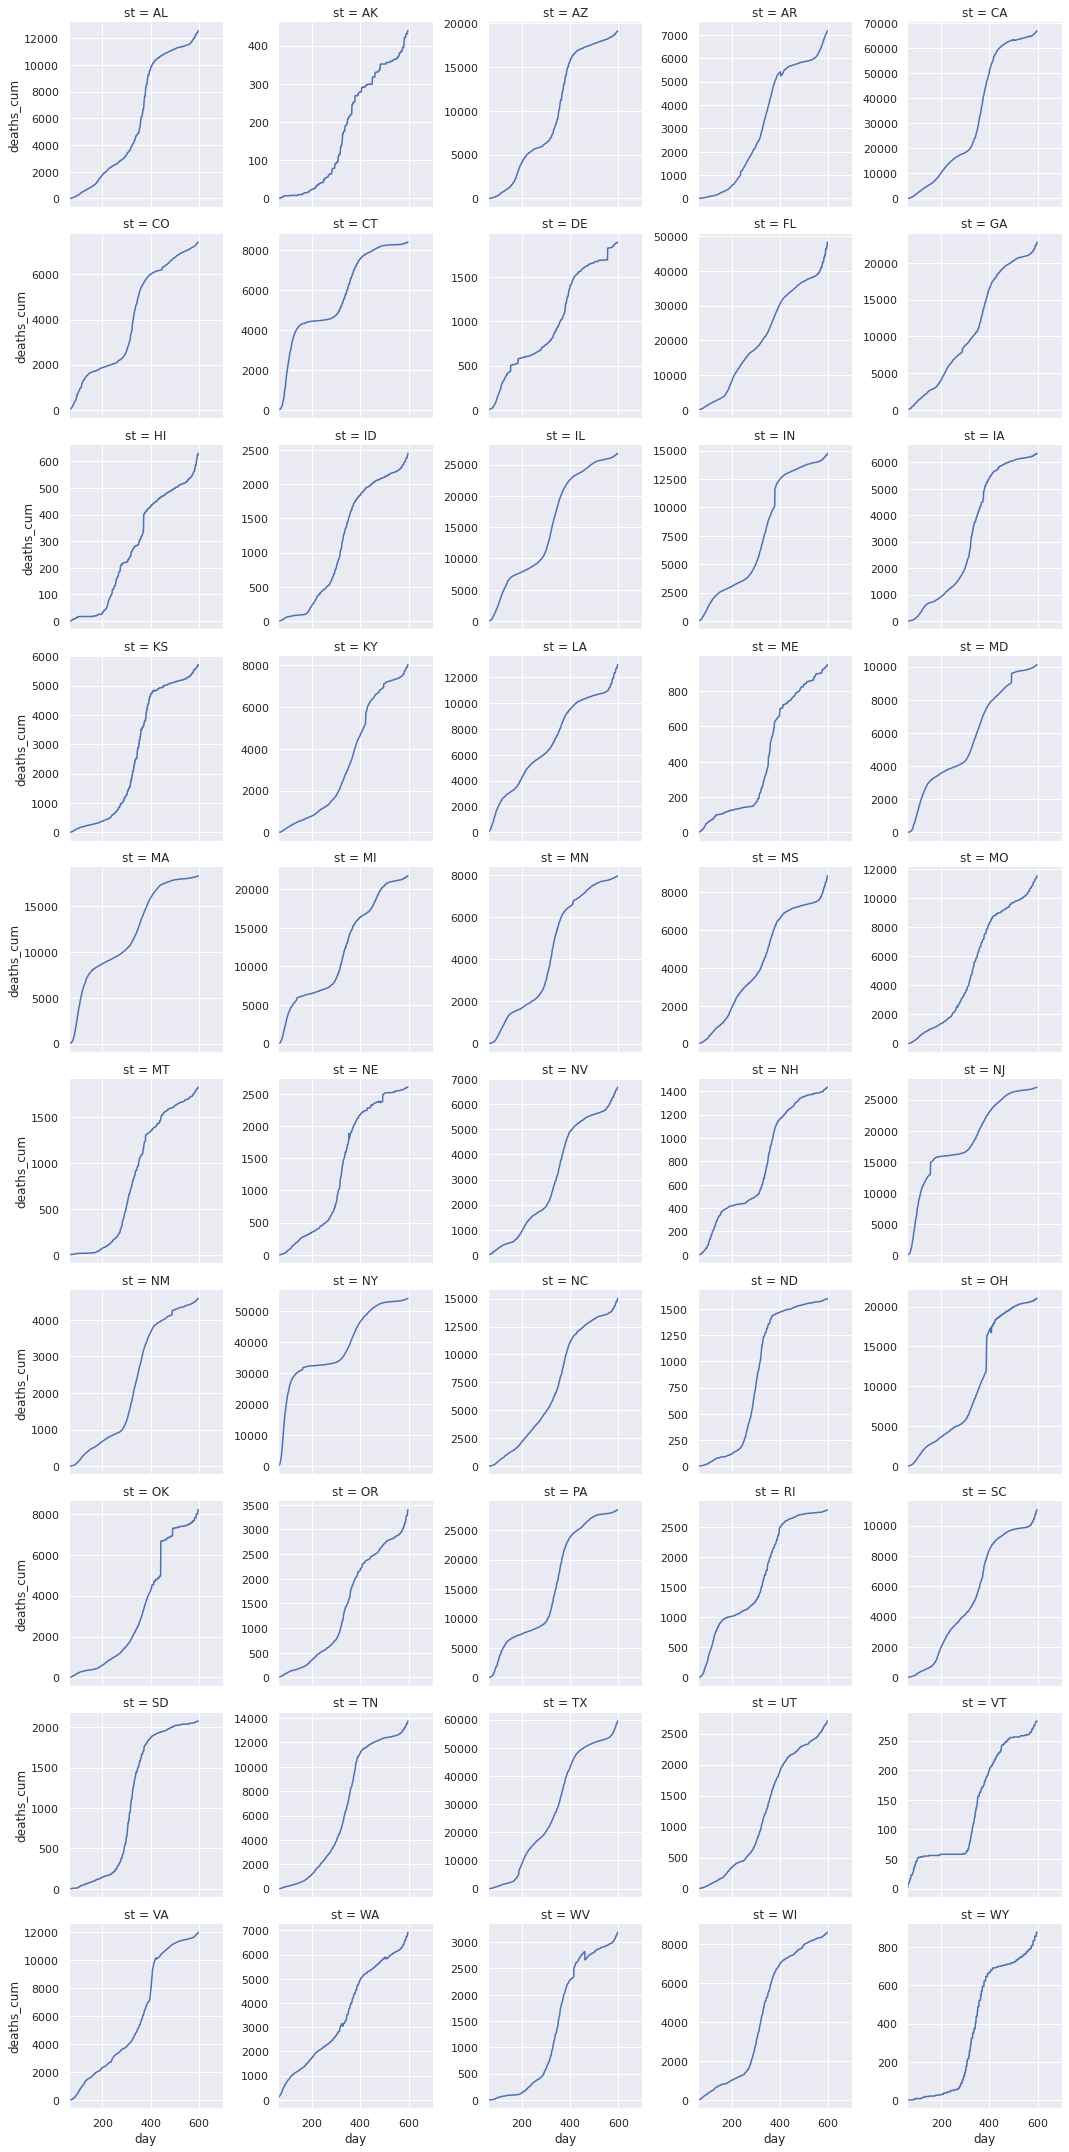

In [53]:
g_states_deaths_cum = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states_deaths_cum = g_states_deaths_cum.map(plt.plot, "day", "deaths_cum")
g_states_deaths_cum.set(xlim=(60,x_end_day))